- in this notebook, the tagged nltk corpus brown will be used to demonstrate POS tagging
- the 'tagset' or format of tagging will be 'universal' (can be changed in the first line)
- the model used will be Hidden Markov Model, and the problem solved will be that of finding
most likely state sequence, the states being the POS tags

In [1]:
import nltk
import librosa
from nltk.corpus import brown
import numpy as np
import matplotlib.pyplot as plt
TAGSET = 'universal'
# nltk.download('popular')    ##run only once

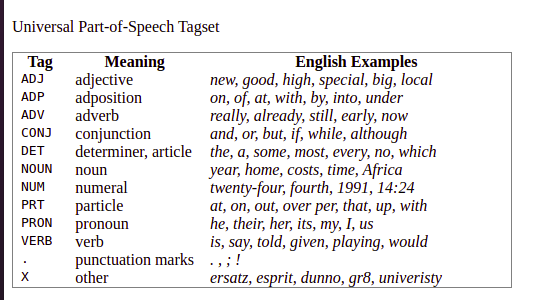

### Exploring brown corpus

In [2]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [3]:
for chosen_category in brown.categories():
    print(chosen_category, len(brown.words(categories = chosen_category)))

adventure 69342
belles_lettres 173096
editorial 61604
fiction 68488
government 70117
hobbies 82345
humor 21695
learned 181888
lore 110299
mystery 57169
news 100554
religion 39399
reviews 40704
romance 70022
science_fiction 14470


In [4]:
for fileid in brown.fileids():
    print(fileid, end='\t')

ca01	ca02	ca03	ca04	ca05	ca06	ca07	ca08	ca09	ca10	ca11	ca12	ca13	ca14	ca15	ca16	ca17	ca18	ca19	ca20	ca21	ca22	ca23	ca24	ca25	ca26	ca27	ca28	ca29	ca30	ca31	ca32	ca33	ca34	ca35	ca36	ca37	ca38	ca39	ca40	ca41	ca42	ca43	ca44	cb01	cb02	cb03	cb04	cb05	cb06	cb07	cb08	cb09	cb10	cb11	cb12	cb13	cb14	cb15	cb16	cb17	cb18	cb19	cb20	cb21	cb22	cb23	cb24	cb25	cb26	cb27	cc01	cc02	cc03	cc04	cc05	cc06	cc07	cc08	cc09	cc10	cc11	cc12	cc13	cc14	cc15	cc16	cc17	cd01	cd02	cd03	cd04	cd05	cd06	cd07	cd08	cd09	cd10	cd11	cd12	cd13	cd14	cd15	cd16	cd17	ce01	ce02	ce03	ce04	ce05	ce06	ce07	ce08	ce09	ce10	ce11	ce12	ce13	ce14	ce15	ce16	ce17	ce18	ce19	ce20	ce21	ce22	ce23	ce24	ce25	ce26	ce27	ce28	ce29	ce30	ce31	ce32	ce33	ce34	ce35	ce36	cf01	cf02	cf03	cf04	cf05	cf06	cf07	cf08	cf09	cf10	cf11	cf12	cf13	cf14	cf15	cf16	cf17	cf18	cf19	cf20	cf21	cf22	cf23	cf24	cf25	cf26	cf27	cf28	cf29	cf30	cf31	cf32	cf33	cf34	cf35	cf36	cf37	cf38	cf39	cf40	cf41	cf42	cf43	cf44	cf45	cf46	cf47	cf48	cg01	cg02	cg03	cg04	cg05	cg06	cg07	cg08	cg09	cg10	cg11	

In [5]:
brown.tagged_words(tagset=TAGSET)

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [6]:
brown.tagged_words()

[('The', 'AT'), ('Fulton', 'NP-TL'), ...]

In [7]:
len(brown.sents())

57340

In [8]:
len(brown.words())

1161192

In [9]:
len(brown.tagged_sents(tagset=TAGSET))

57340

In [10]:
len(brown.tagged_sents())

57340

### universal tagset to keep the tags simpler

In [11]:
dataset = brown.tagged_sents(tagset=TAGSET)

# sample output
print(dataset[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


### method to split single tagged_sents

In [12]:
def split_word_tag_sentence(word_tag_sentence):
    word_sentence = [word_tag[0] for word_tag in word_tag_sentence]
    tag_sentence = [word_tag[1] for word_tag in word_tag_sentence]
    return word_sentence, tag_sentence
word_sentence, tag_sentence = split_word_tag_sentence(dataset[0])
print(word_sentence)
print(tag_sentence)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


In [13]:
train_tagged_sents = dataset[:40000]
test_tagged_sents = dataset[40000:]
print(len(train_tagged_sents))
print(len(test_tagged_sents))

40000
17340


In [14]:
def collect_word_and_tag_sentences(word_tag_sentence_collection):
    tag_sentences = []
    word_sentences = []
    for word_tag_sentence in word_tag_sentence_collection:
        word_sentence, tag_sentence = split_word_tag_sentence(word_tag_sentence)
        tag_sentences.append(tag_sentence)
        word_sentences.append(word_sentence)
    return word_sentences, tag_sentences
train_word_sentences, train_tag_sentences = collect_word_and_tag_sentences(train_tagged_sents)
test_word_sentences, test_tag_sentences = collect_word_and_tag_sentences(test_tagged_sents)

In [15]:
print(len(train_word_sentences))
print(len(train_tag_sentences))
print(len(test_word_sentences))
print(len(test_tag_sentences))

40000
40000
17340
17340


### import numpy

In [16]:
train_rand = np.random.randint(len(train_word_sentences))
test_rand = np.random.randint(len(test_word_sentences))
print(train_word_sentences[train_rand])
print(train_tag_sentences[train_rand])
print(test_word_sentences[test_rand])
print(test_tag_sentences[test_rand])

['Babe', 'Ruth', ',', 'as', 'he', 'always', 'did', 'in', 'the', 'Stadium', ',', 'played', 'right', 'field', 'to', 'avoid', 'having', 'the', 'sun', 'in', 'his', 'eyes', ',', 'and', 'Tommy', 'Thevenow', ',', 'a', 'rather', 'mediocre', 'hitter', 'who', 'played', 'shortstop', 'for', 'the', 'St.', 'Louis', 'Cardinals', ',', 'knocked', 'a', 'ball', 'with', 'all', 'his', 'might', 'into', 'the', 'sharp', 'angle', 'formed', 'by', 'the', 'permanent', 'stands', 'and', 'the', 'wooden', 'bleachers', ',', 'where', 'Ruth', 'could', 'not', 'reach', 'it', '.']
['NOUN', 'NOUN', '.', 'ADP', 'PRON', 'ADV', 'VERB', 'ADP', 'DET', 'NOUN', '.', 'VERB', 'ADJ', 'NOUN', 'PRT', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', '.', 'CONJ', 'NOUN', 'NOUN', '.', 'DET', 'ADV', 'ADJ', 'NOUN', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', '.', 'VERB', 'DET', 'NOUN', 'ADP', 'PRT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'CONJ', 'DET', 'ADJ', 'NOUN', '.', 'ADV'

### all possible unique states

In [17]:
STATES = dict()
count = 0
for sent in train_tag_sentences:
    for tag in sent:
        if tag not in STATES:
            STATES[tag] = count
            count += 1
REVERSE_STATES = {v:k for k,v in STATES.items()}

In [18]:
STATES

{'DET': 0,
 'NOUN': 1,
 'ADJ': 2,
 'VERB': 3,
 'ADP': 4,
 '.': 5,
 'ADV': 6,
 'CONJ': 7,
 'PRT': 8,
 'PRON': 9,
 'NUM': 10,
 'X': 11}

##### initial probabilities

In [19]:
%%time
### init probs
init_probs = np.zeros(len(STATES))
print(init_probs)
for sent in train_tag_sentences:
    init_probs[STATES[sent[0]]] +=1
        
# ### trans probs
# trans_probs = np.
print(init_probs)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9885. 5983. 1728. 1899. 5839. 1923. 3738. 2027. 1245. 4884.  829.   20.]
CPU times: user 37.2 ms, sys: 58 µs, total: 37.3 ms
Wall time: 36.6 ms


#### transition probabilities

In [20]:
%%time
### trans probs
trans_probs = np.zeros((len(STATES), len(STATES)))
print(trans_probs)
for sent in train_tag_sentences:
    for i in range(len(sent) - 1):
        tag = STATES[sent[i]]
        next_tag = STATES[sent[i+1]]
        trans_probs[tag, next_tag] += 1
print(trans_probs)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[6.9200e+02 6.5271e+04 2.6753e+04 7.1530e+03 1.0270e+03 1.3410e+03
  1.9700e+03 6.7000e+01 1.6300e+02 1.0190e+03 1.0940e+03 1.3500e+02]
 [3.4930e+03 3.5318e+04 2.9930e+03 3.4329e+04 5.7109e+04 6.1123e+04
  5.3430e+03 1.3271e+04 3.7760e+03 3.9770e+03 2.1350e+03 8.4000e+01]
 [3.6800e+02 4.6466e+04 4.0460e+03 1.2130e+03 5.9730e+03 6.0660e+03
  5.5200e+02 2.5480e+03 1.2690e+03 1.7700e+02 5.1900e+02 3.4000e+01]
 [2.2001e+04 1.4084e+04 8.4130e+03 2.5702e+04 2.3762e+04 9.5670e+03
  1.3943e+04 1.9580e+03 7.7890e+03 5.2440e+03 1.3460

#### probability of each state given a word that occurs in a sentence

- no stemming or lemmatization

In [21]:
UNIQUE_WORDS = dict()
count = 0
for sent in train_word_sentences:
    for word in sent:
        if word not in UNIQUE_WORDS:
            UNIQUE_WORDS[word] = count
            count+=1
# print(UNIQUE_WORDS)

In [22]:
len(UNIQUE_WORDS)

49136

In [23]:
#### normalizing each matrix

In [24]:
init_probs = init_probs / init_probs.sum()
sum_of_rows = trans_probs.sum(axis=1)
trans_probs = trans_probs /sum_of_rows[:, np.newaxis]


In [25]:
### verifying rows sum to 1
sum(init_probs)
for row in range(trans_probs.shape[0]):
    print(trans_probs[row].sum())

1.0
0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0
1.0000000000000002
1.0
1.0
1.0
1.0


In [26]:
%%time
prob_tag_word = np.zeros((len(UNIQUE_WORDS), len(STATES)))
for word_sent, tag_sent in zip(train_word_sentences, train_tag_sentences):
    for word, tag in zip(word_sent, tag_sent):
        prob_tag_word[UNIQUE_WORDS[word], STATES[tag]] += 1

CPU times: user 765 ms, sys: 8.09 ms, total: 773 ms
Wall time: 774 ms


In [27]:
%%time
row_sums = prob_tag_word.sum(axis = 1)
prob_tag_word = prob_tag_word /row_sums[:, np.newaxis]
for row in range(prob_tag_word.shape[0]):
    print(prob_tag_word[row].sum())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [28]:
prob_tag_word.shape

(49136, 12)

In [29]:
### random test sentence for determining POS tag
def run_pos_tag():
    indx = np.random.randint(test_rand)
    test_word_sentence = test_word_sentences[indx]
    test_tag_sentence = test_tag_sentences[indx]
    print(test_word_sentence, end = '\n\n')
    ### emission prob for each word in the sentence
    emission_prob = np.zeros((len(STATES), len(test_word_sentence)))
    ## emission prob for the sentence
    for i, word in enumerate(test_word_sentence):
        if word not in UNIQUE_WORDS:
            emission_prob[11, i] = 1
        else:
            emission_prob[:, i] = prob_tag_word[UNIQUE_WORDS[word],:]
    ## calculating the tags on the sequence
    pos_seq = librosa.sequence.viterbi_discriminative(
        prob = emission_prob,
        transition = trans_probs,
        p_init = init_probs)

    ### output sequence with words and corresponding tags
    print('word | obtained tag | original tag')
    for i, word in enumerate(test_word_sentence):
        print('{} | {} | {}'.format(word, REVERSE_STATES[pos_seq[i]],
                                    test_tag_sentence[i]), end='\n')
    plt.imshow(emission_prob)

['The', 'place', 'smelt', 'of', 'some', 'kind', 'of', 'hair', 'lotion', 'these', 'pimplike', 'characters', 'use', '.']

word | obtained tag | original tag
The | DET | DET
place | NOUN | NOUN
smelt | X | VERB
of | ADP | ADP
some | DET | DET
kind | NOUN | NOUN
of | ADP | ADP
hair | NOUN | NOUN
lotion | X | NOUN
these | DET | DET
pimplike | X | ADJ
characters | NOUN | NOUN
use | NOUN | VERB
. | . | .


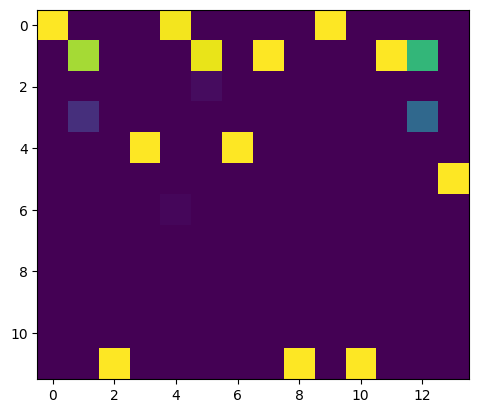

In [37]:
run_pos_tag()

In [31]:
## HMM LEARN LIBRARY

In [32]:
# train_lengths = []
# for sent in train_tag_sentences:
#     train_lengths.append(len(sent))

https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_multinomial_hmm.html#sphx-glr-auto-examples-plot-multinomial-hmm-py

In [33]:
# ## the X to give HMM model
# len(train_tag_sentences)

In [34]:
# %%time
# import numpy as np
# from hmmlearn import hmm

# # For this example, we will model the stages of a conversation,
# # where each sentence is "generated" with an underlying topic, "cat" or "dog"
# states = list(STATES.keys())
# id2topic = dict(zip(range(len(states)), states))
# # we are more likely to talk about cats first
# start_probs = init_probs

# # For each topic, the probability of saying certain words can be modeled by
# # a distribution over vocabulary associated with the categories

# vocabulary = list(UNIQUE_WORDS.keys())
# # if the topic is "cat", we are more likely to talk about "mouse"
# # if the topic is "dog", we are more likely to talk about "fetch"
# emission_probs = emission_prob

# # Also assume it's more likely to stay in a state than transition to the other
# trans_mat = trans_probs


# # Convert "sentences" to numbers:
# vocab2id = dict(zip(vocabulary, range(len(vocabulary))))
# def sentence2counts(sentence):
#     ans = []
#     for word, idx in vocab2id.items():
#         count = sentence.count(word)
#         ans.append(count)
#     return ans

# X = []
# for sentence in train_word_sentences:
#     row = sentence2counts(sentence)
#     X.append(row)

# # pretend this is repeated, so we have more data to learn from:
# # lengths = [len(X)]*5
# # sequences = np.tile(data, (5,1))



In [35]:
# # Set up model:
# model = hmm.MultinomialHMM(n_components=len(states),
#         n_iter=1,
#         init_params='')

# model.n_features = len(vocabulary)
# model.startprob_ = start_probs
# model.transmat_ = trans_mat
# model.emissionprob_ = emission_probs
# model.fit(X, lengths)

In [36]:
# %%time

# logprob, received = model.decode(X_test)
# print("Topics discussed:")
# print([id2topic[x] for x in received])

# print("Learned emission probs:")
# print(model.emissionprob_)

# print("Learned transition matrix:")
# print(model.transmat_)

# # Try to reset and refit:
# new_model = hmm.MultinomialHMM(n_components=len(states),
#         n_iter=50, init_params='ste')

# new_model.fit(sequences, lengths)
# logprob, received = new_model.decode(sequences)

# print("\nNew Model")
# print("Topics discussed:")
# print([id2topic[x] for x in received])

# print("Learned emission probs:")
# print(new_model.emissionprob_)

# print("Learned transition matrix:")
# print(new_model.transmat_)